# Classification

In [1]:
import os

In [2]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 1) MNIST

Due to internet access difficuilty, I will use digits built in dataset instead of MNIST hand written digits.
Need to redo the session with MNIST data once connection got restored.

In [3]:
from sklearn.datasets import load_digits
import numpy as np

In [4]:
mnist = load_digits()
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [5]:
X, y = mnist['data'], mnist['target']

In [6]:
X.shape

(1797, 64)

In [7]:
y.shape

(1797,)

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl

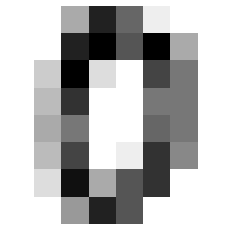

In [17]:
some_digit = X[0]
some_digit_image = some_digit.reshape(8, 8)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [18]:
y[0]

0

The label tell us that it is zero 0.

In [25]:
y = y.astype(np.uint8)

In [26]:
y

array([0, 1, 2, ..., 8, 9, 8], dtype=uint8)

In [115]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 8
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


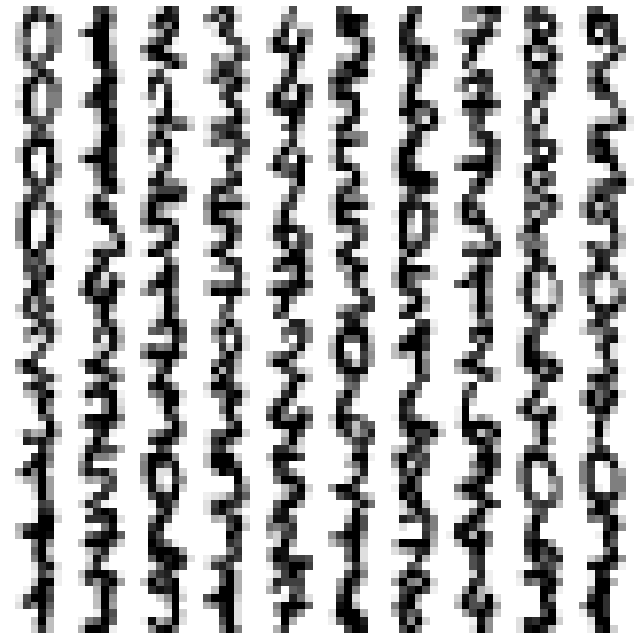

In [36]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

------

# Training a Binary Classifier 
Let's try to solve a simple classification between 5 or not 5.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437,), (360,))

### As our problem is binary classification of 5 or not 5, we need to prepare for labels for 5.

In [11]:
y_train_5 = (y_train==5) # True for all 5s, False for all other digits
y_train_5

array([False, False, False, ..., False, False, False])

In [12]:
y_test_5 = (y_test == 5)

### Classification using SGD classifier (Stochastic Gradient Descent)
- has advantage or handling large dataset efficiently because SGD deals with training instances indenpently, one at a time.
- will suited for online learning.

**TIPS: The SGDClassifier relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you should set the random_state parameter.**

In [19]:
from sklearn.linear_model import SGDClassifier

In [20]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [21]:
# test using our single digit which is 0
# returns False as prediction which is correct as this is not digit 5.
sgd_clf.predict([some_digit])

array([False])

------

# 3) Performance Measures

## 3.1) Measuring Accuracy using Cross Validation

### 1) using off the shelf cross validation

In [22]:
# off the shelf cross validation
from sklearn.model_selection import cross_val_score

In [23]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.98121086, 0.98538622, 0.98956159])

### 2) using StratifiedKFold which give the same result as off the shelf one

At each iteration the
code creates a clone of the classifier, trains that clone on the training folds, and makes
predictions on the test fold. Then it counts the number of correct predictions and
outputs the ratio of correct predictions.

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [25]:
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=3)

In [26]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) # clone the estimator
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / (len(y_pred)))

0.9895615866388309
0.9916492693110647
0.9895615866388309


### Let's create a dumb Classifer which always predict not 5 all the time

In [27]:
from sklearn.base import BaseEstimator

In [28]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros(shape=(len(X), 1), dtype=bool)

In [29]:
# can we guess this model's accuracy?
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90605428, 0.90605428, 0.90605428])

Even the dumb classifier who always predict NOT 5 all the time got accuracy of 90% +. This is bad.

**This demostrates why Accuracy is generally not the preferred performance measure for Classifiers, especially when we are dealing with skewed datasets (i.e., when some classes are much more frequent than others)**

--------

## 3.2) Confusion Matrix

The general idea is to count the number of times instances of class A are classified as class B.

For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the fifth row and third column of the confusion
matrix.

![confusion_matrix](images/confusion_matrix.png)

### using cross_val_predict()

performs K-fold
cross-validation, but instead of returning the evaluation scores, it returns the predictions
made on each test fold. This means that you get a clean prediction for each
instance in the training set (“clean” meaning that the prediction is made by a model
that never saw the data during training).

In [30]:
from sklearn.model_selection import cross_val_predict

In [31]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

y_train_pred

array([False, False, False, ..., False, False, False])

### using Confusion matrix to see the performances

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
confusion_matrix(y_train_5, y_train_pred)

array([[1282,   20],
       [   7,  128]], dtype=int64)

In [34]:
# if we have a perfect classifier, the confusion matrix will be look like below
confusion_matrix(y_train_5, y_train_5)

array([[1302,    0],
       [   0,  135]], dtype=int64)

## 3.3) Precision and Recall

In [35]:
from sklearn.metrics import precision_score, recall_score

In [36]:
precision_score(y_train_5, y_train_pred)

0.8648648648648649

In [37]:
recall_score(y_train_5, y_train_pred)

0.9481481481481482

## F1 Score (harmonic mean)
It is often convenient to combine precision and recall into a single metric called the F1
score, in particular if you need a simple way to compare two classifiers. 

**The F1 score is
the harmonic mean of precision and recall**. 
+ Whereas the **regular mean treats all values equally, the harmonic mean gives much more weight to low values**. F1 score raises the flag if one of (precision or recall) is lower than other.
+ As a result, the classifier will only get a high F1 score if both recall and precision are high.
+ F1 score is always lower than Arithmetic Mean (regular mean).

![](images/f1score.png)


In [38]:
from sklearn.metrics import f1_score

In [39]:
f1_score(y_train_5, y_train_pred)

0.9045936395759717

The F1 score favors classifiers that have similar precision and recall. 

### This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. 

+ For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). 
+ On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called **the precision/recall trade-off**.

![](images/precision_recall_2.png)

## 3.4) Precision / Recall Trade Off

To understand this trade-off, let’s look at how the SGDClassifier makes its classificationdecisions. 

For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class;
otherwise it assigns it to the negative class. 

The following figure shows a few digits positioned from the lowest score on the left to the highest score on the right. Suppose the decision
threshold is positioned at the central arrow (between the two 5s): you will find 4 true positives (actual 5s) on the right of that threshold, and 1 false positive (actually a 6). Therefore, with that threshold, the precision is 80% (4 out of 5). But out of 6
actual 5s, the classifier only detects 4, so the recall is 67% (4 out of 6). 

If you raise the threshold (move it to the arrow on the right), the false positive (the 6) becomes a true negative, thereby increasing the precision (up to 100% in this case), but one true positive becomes a false negative, decreasing recall down to 50%. Conversely, lowering the threshold increases recall and reduces precision.



![precision_recall](images/precision_recall.png)

Scikit-Learn does not let you set the threshold directly, but it does give you access to
the decision scores that it uses to make predictions. Instead of calling the classifier’s
predict() method, you can call its decision_function() method, which returns a
score for each instance, and then use any threshold you want to make predictions
based on those scores:

In [40]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-2318.69561367])

In [41]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

The SGDClassifier uses a threshold equal to 0, so the previous code returns the same
result as the predict() method (i.e., False). Let’s lower the threshold

In [42]:
threshold = -2400
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

### So how can we decide which threadshold to use?

First, use the cross_val_predict()
function to get the scores of all instances in the training set, but this time specify that
you want to return decision scores instead of predictions:

In [43]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                                            method='decision_function')

y_scores

array([-2918.65958237, -4263.7564872 , -4602.77876085, ...,
       -8607.23554663, -4160.05032491, -5083.69226976])

With these scores, use the precision_recall_curve() function to compute precision
and recall for all possible thresholds:

In [44]:
from sklearn.metrics import precision_recall_curve

In [45]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [46]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall')
    
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)          # Not shown
    plt.grid(True)                                            # Not shown
    plt.axis([-50000, 50000, 0, 1])                    # Not shown

Saving figure precision_recall_vs_threshold_plot


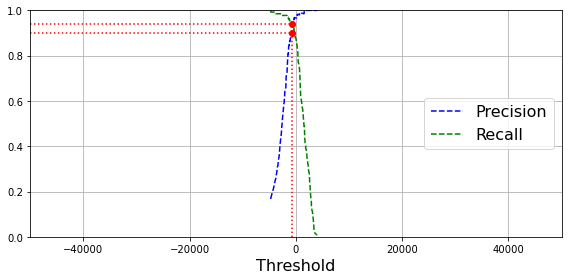

In [47]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                              # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")    # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                            # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                    # Not shown
save_fig("precision_recall_vs_threshold_plot")                                          # Not shown
plt.show()

In [48]:
(y_train_pred == (y_scores > 0)).all()

False

Saving figure precision_vs_recall_plot


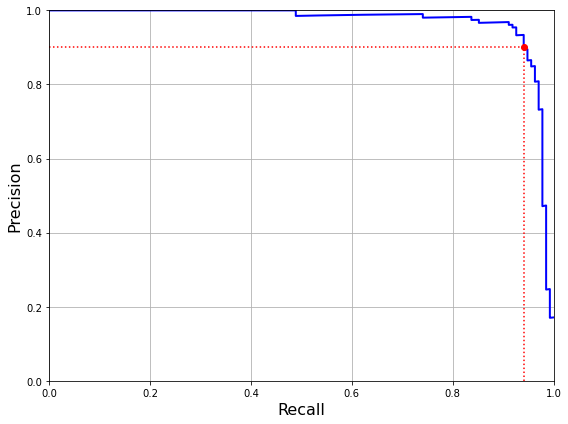

In [49]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [50]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

threshold_90_precision

-709.6901272966708

In [51]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90)

0.900709219858156

In [52]:
recall_score(y_train_5, y_train_pred_90)

0.9407407407407408

## 3.5) The ROC Curve

![](images/roccurve.png)
![](images/roccurve2.png)

In [53]:
from sklearn.metrics import roc_curve

In [55]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


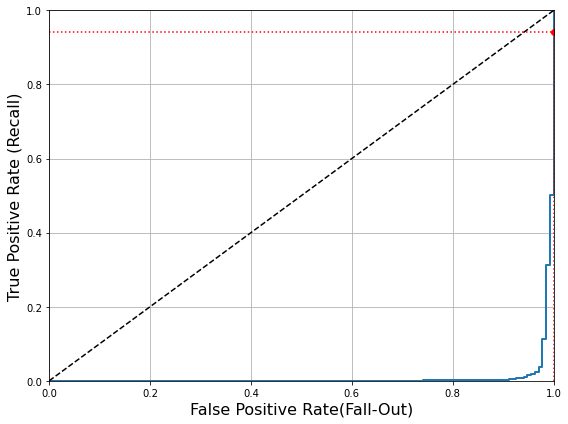

In [69]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--') #dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate(Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)
    
    

plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro") 
save_fig("roc_curve_plot")
plt.show()

In [70]:
from sklearn.metrics import roc_auc_score

In [71]:
roc_auc_score(y_train_5, y_scores)

0.9916197303294078

------

### Using RandomForest Classifier 

- it doesn't have decision function() instead, it has `predict_proba()` method.
- The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=5, method='predict_proba')

The roc_curve() function expects labels and scores, but instead of scores you can
give it class probabilities.

In [74]:
y_probas_forest

array([[0.96, 0.04],
       [0.96, 0.04],
       [0.99, 0.01],
       ...,
       [1.  , 0.  ],
       [0.99, 0.01],
       [1.  , 0.  ]])

In [75]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Saving figure roc_curve_comparison_plot


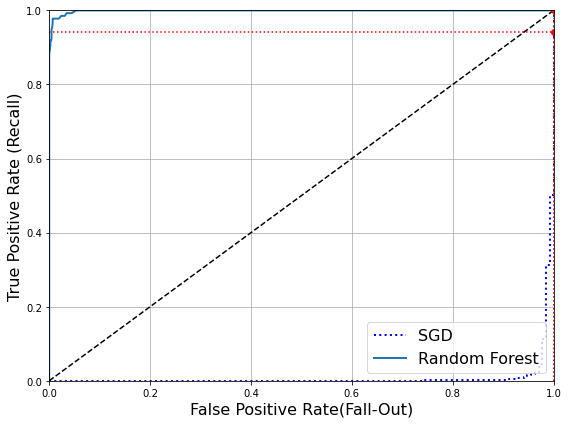

In [77]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

Comparing ROC curves: the Random Forest classifier is superior to the SGD
classifier because its ROC curve is much closer to the top-left corner, and it has a greater
AUC

In [78]:
roc_auc_score(y_train_5, y_scores_forest)

0.9988621493997838

In [79]:
# precision and recall score
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [80]:
precision_score(y_train_5, y_train_pred_forest)

1.0

In [81]:
recall_score(y_train_5, y_train_pred_forest)

0.8148148148148148

----------

## 4) Multiclass Classification
- algorithms such as SGD classifier, Random Forest Classifier, Naive Bayes Classifier are capable of handling multiclass natively.
- Others (such as Logistic Regression or Support Vector Machine Classifier) are **strictly binary classifier**

### However, there are various strategies that we can perform multiclass classification using multiple binary classifier.
- One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2- detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the **one-versus-the-rest (OvR) strategy (also calledone-versus-all)**.
- Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the **one-versus-one (OvO) strategy**. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish. Example: SVM classifers work well with this approach.

In [82]:
from sklearn.svm import SVC

In [84]:
svm_clf = SVC()

svm_clf.fit(X_train, y_train) # every instances of y, not y_train_5
svm_clf.predict([some_digit])

array([0])

This above code trains the SVC on the training set using the original target
classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes
(y_train_5). Then it makes a prediction (a correct one in this case). Under the hood,
Scikit-Learn actually used the OvO strategy:it trained 45 binary classifiers, got their
decision scores for the image, and selected the class that won the most duels.

If you call the decision_function() method, you will see that it returns 10 scores
per instance (instead of just 1). That’s one score per class:

In [86]:
some_digit_scores = svm_clf.decision_function([some_digit])

some_digit_scores

array([[ 9.30885507, -0.2948184 ,  2.75850062,  4.82765698,  3.76760135,
         7.2142768 ,  1.76365249,  0.75646487,  6.12400772,  8.26383968]])

The highest score is indeed the one corresponding to class of correct digit

In [87]:
np.argmax(some_digit_scores)

0

In [88]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [89]:
svm_clf.classes_[0]

0

### We can also force SK learn to use one-verus-one or one-verus-rest by using `OneVsOneClassifier` or `OneVsRestClassifier`

### OneVsRest Classifier

In [91]:
from sklearn.multiclass import OneVsRestClassifier

In [97]:
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42)) #using SVC 

ovr_clf.fit(X_train, y_train)

ovr_clf.predict([some_digit])

array([0])

In [98]:
len(ovr_clf.estimators_)

10

### Training an SGDClassifier (or a RandomForestClassifier) is just as easy:

This time Scikit-Learn did not have to run OvR or OvO because SGD classifiers can
directly classify instances into multiple classes. The decision_function() method
now returns one value per class. Let’s look at the score that the SGD classifier assigned
to each class:

In [100]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([0])

You can see that the classifier is fairly confident about its prediction: almost all scores
are largely negative,

In [101]:
sgd_clf.decision_function([some_digit])

array([[ 2526.95077122, -2904.58862349, -2859.84678851, -1902.43034813,
        -1456.64955425, -2460.83815085, -1867.42798836,  -421.68145365,
        -1290.16515015, -1037.21835373]])

Now of course you want to evaluate this
classifier. As usual, you can use cross-validation. Use the cross_val_score() function
to evaluate the SGDClassifier’s accuracy:

In [102]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.9519833 , 0.95615866, 0.93319415])

#### After scaling,

In [103]:
from sklearn.preprocessing import StandardScaler

In [104]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [105]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.93319415, 0.95824635, 0.91858038])

-------

## 5) Error Analysis

In [106]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[143,   0,   0,   0,   0,   0,   1,   0,   1,   0],
       [  0, 140,   0,   2,   0,   0,   1,   0,   7,   4],
       [  0,   1, 136,   2,   0,   0,   0,   1,   4,   0],
       [  0,   0,   0, 132,   0,   4,   0,   4,   8,   1],
       [  0,   4,   0,   0, 125,   0,   0,   1,   4,   1],
       [  0,   0,   0,   0,   0, 127,   0,   2,   3,   3],
       [  0,   1,   0,   0,   0,   0, 142,   0,   3,   0],
       [  0,   0,   0,   1,   2,   0,   0, 138,   3,   1],
       [  0,   7,   0,   2,   0,   0,   0,   0, 135,   0],
       [  0,   2,   0,   3,   0,   2,   0,   1,   4, 128]], dtype=int64)

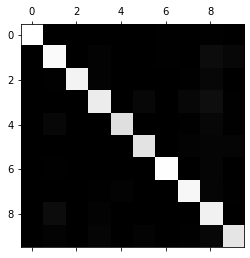

In [108]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show();

This confusion matrix looks pretty good, since most images are on the main diagonal,
which means that they were classified correctly. The 5s look slightly darker than
the other digits, which could mean that there are fewer images of 5s in the dataset or
that the classifier does not perform as well on 5s as on other digits. In fact, you can
verify that both are the case.

In [109]:
from sklearn.metrics import plot_confusion_matrix

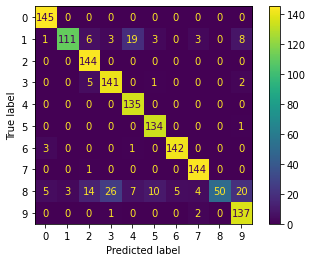

In [110]:
plot_confusion_matrix(sgd_clf, X_train_scaled, y_train);

Let’s focus the plot on the errors. First, you need to divide each value in the confusion
matrix by the number of images in the corresponding class so that you can compare
error rates instead of absolute numbers of errors (which would make abundant
classes look unfairly bad):

In [111]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Fill the diagonal with zeros to keep only the errors, and plot the result:

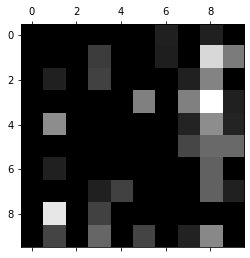

In [113]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show();

You can clearly see the kinds of errors the classifier makes. **Remember that rows represent
actual classes, while columns represent predicted classes**. 

The column for class
8 is quite bright, which tells you that many images get misclassified as 8s. However,
the row for class 8 is not that bad, telling you that actual 8s in general get properly
classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical.
You can also see that 3s and 5s often get confused (in both directions)

Analyzing the confusion matrix often gives you insights into ways to improve your
classifier. Looking at this plot, it seems that your efforts should be spent on reducing
the false 8s. For example, you could try to gather more training data for digits that
look like 8s (but are not) so that the classifier can learn to distinguish them from real
8s. Or you could engineer new features that would help the classifier—for example,
writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5
has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or
OpenCV) to make some patterns, such as closed loops, stand out more.

### Analyzing individual errors can also be a good way to gain insights 
on what your
classifier is doing and why it is failing, but it is more difficult and time-consuming.
For example, let’s plot examples of 3s and 5s (the plot_digits() function just uses
Matplotlib’s imshow() function

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()